In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import torch
import pandas as pd
from transformers import BertTokenizer, BertModel, TFBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import accuracy_score, classification_report,recall_score,precision_score,f1_score,fbeta_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#%pip install Sastrawi
#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

label_type = ['NotPromotion', 'Promotion']

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
combined_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/dataset_combined_new - dataset_combined_new.csv', encoding='utf-8', index_col=False)
train_data=pd.read_csv('/kaggle/input/dataset-scraping-sendiri/train.csv')
val_data=pd.read_csv('/kaggle/input/dataset-scraping-sendiri/val.csv')
test_data=pd.read_csv('/kaggle/input/dataset-scraping-sendiri/test.csv')

In [3]:
combined_data.isna().sum()

text     0
label    0
dtype: int64

In [4]:
#Ensure string datatypes
combined_data['text']=combined_data['text'].astype(str)
train_data['text']=train_data['text'].astype(str)
val_data['text']=val_data['text'].astype(str)
test_data['text']=test_data['text'].astype(str)

In [5]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu']
stopwords += custom_stopwords

pattern = r"[^A-Za-z ]"

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r"[^A-Za-z ]", "", text.lower())  # Remove non-alphabet characters
    word_list = word_tokenize(text)
    word_list = [word for word in word_list if word not in stopwords]
    return " ".join(word_list) 

In [6]:
combined_data['text'] = combined_data['text'].apply(preprocess_text)
train_data['text']=train_data['text'].apply(preprocess_text)
val_data['text']=val_data['text'].apply(preprocess_text)
test_data['text']=test_data['text'].apply(preprocess_text)

In [7]:
texts = combined_data['text'].values
labels = combined_data['label'].values

train_texts = train_data['text'].values
train_labels = train_data['label'].values

val_texts = val_data['text'].values
val_labels = val_data['label'].values

test_texts = test_data['text'].values
test_labels = test_data['label'].values

In [8]:
texts

array(['game slot online terpercaya winning sering kasih bonus',
       'raffi situs resmi slot gacor anti rungkad terbaik bandar togel terpercaya indonesia',
       'sendok bonus deposit redeposit', ..., 'kocaaakkkkk', 'panikk',
       'malah end'], dtype=object)

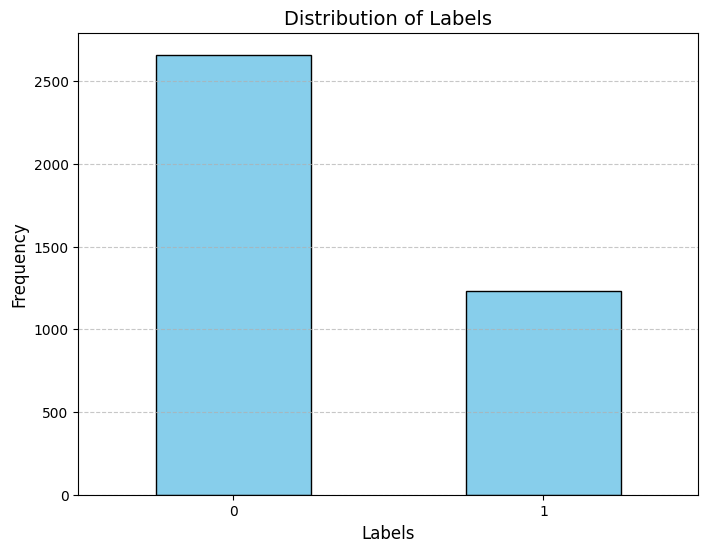

In [9]:
label_counts = combined_data['label'].value_counts()
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Distribution of Labels', fontsize=14)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

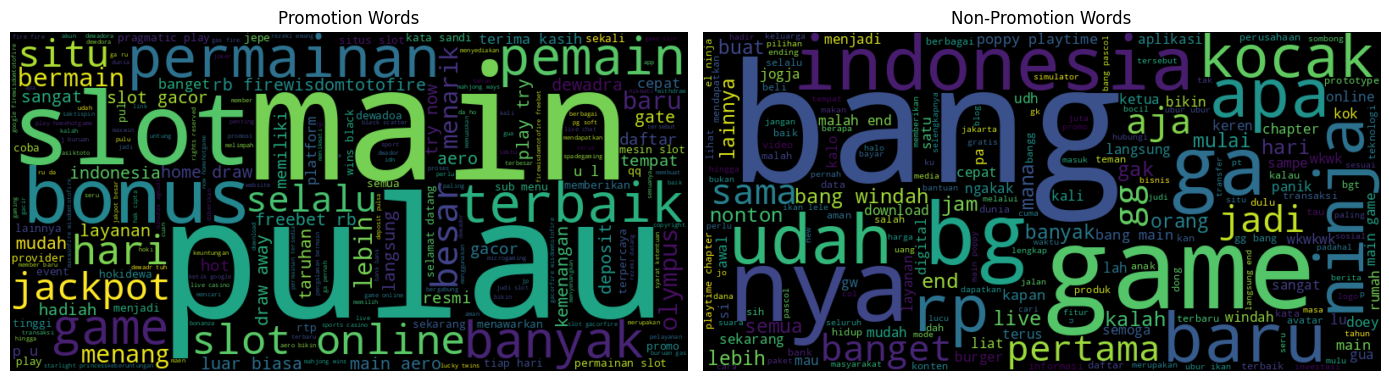

In [10]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate the texts by class
promotion_texts = texts[labels == 1]
non_promotion_texts = texts[labels == 0]

# Generate wordcloud for each class
promotion_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(promotion_texts))
non_promotion_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(non_promotion_texts))

# Plot the wordclouds
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(promotion_wordcloud, interpolation='bilinear')
axes[0].set_title("Promotion Words")
axes[0].axis("off")

axes[1].imshow(non_promotion_wordcloud, interpolation='bilinear')
axes[1].set_title("Non-Promotion Words")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [11]:
#x_train,x_temp,y_train,y_temp=train_test_split(texts,labels, test_size=0.2, random_state=42,stratify=labels)
#x_test,x_val,y_test,y_val=train_test_split(x_temp,y_temp,test_size=0.5,random_state=42,stratify=y_temp)

In [12]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_function(texts):
    return tokenizer(texts,padding=True,truncation=True, return_tensors='tf', max_length=128)

train_encodings = tokenize_function(train_texts.tolist())
val_encodings = tokenize_function(val_texts.tolist())
test_encodings = tokenize_function(test_texts.tolist())

model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2,from_pt=True)

epochs = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./checkpoint',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    train_labels,
    validation_data=([val_encodings['input_ids'], val_encodings['attention_mask']],val_labels),
    batch_size=16,
    epochs=epochs,
    class_weight=class_weights,  
    callbacks=[checkpoint_callback]
)

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
171/171 [==============================] - ETA: 0s - loss: 0.4167 - accuracy: 0.7727
Epoch 1: val_accuracy improved from -inf to 0.86297, saving model to ./checkpoint
171/171 [==============================] - 84s 308ms/step - loss: 0.4167 - accuracy: 0.7727 - val_loss: 0.2868 - val_accuracy: 0.8630
Epoch 2/10
171/171 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.9430
Epoch 2: val_accuracy improved from 0.86297 to 0.93878, saving model to ./checkpoint
171/171 [==============================] - 48s 279ms/step - loss: 0.1671 - accuracy: 0.9430 - val_loss: 0.1539 - val_accuracy: 0.9388
Epoch 3/10
171/171 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.9773
Epoch 3: val_accuracy improved from 0.93878 to 0.97085, saving model to ./checkpoint
171/171 [==============================] - 48s 279ms/step - loss: 0.0819 - accuracy: 0.9773 - val_loss: 0.0832 - val_accuracy: 0.9708
Epoch 4/10
171/171 [==============================] - ETA:

In [13]:
pred = model.predict([test_encodings['input_ids'], test_encodings['attention_mask']])

11/11 [==============================] - 4s 161ms/step


In [14]:
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import average_precision_score

y_probs = tf.nn.softmax(pred.logits, axis=-1).numpy()[:, 1]

precisions, recalls, thresholds = precision_recall_curve(test_labels, y_probs)

f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_idx = f1s.argmax()
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {f1s[best_idx]:.4f}")

ap_score = average_precision_score(test_labels, y_probs)
print(f"Average Precision (AP) Score: {ap_score:.4f}")


Best Threshold: 0.8761
Best F1-Score: 0.9492
Average Precision (AP) Score: 0.9860


Accuracy Score: 0.9737
Recall Score: 0.9130
Precision Score: 0.9882
F1 Score: 0.9492
Fbeta Score: 0.9722
Classification Report:               precision    recall  f1-score   support

NotPromotion       0.97      1.00      0.98       250
   Promotion       0.99      0.91      0.95        92

    accuracy                           0.97       342
   macro avg       0.98      0.95      0.97       342
weighted avg       0.97      0.97      0.97       342

Confusion Matrix:



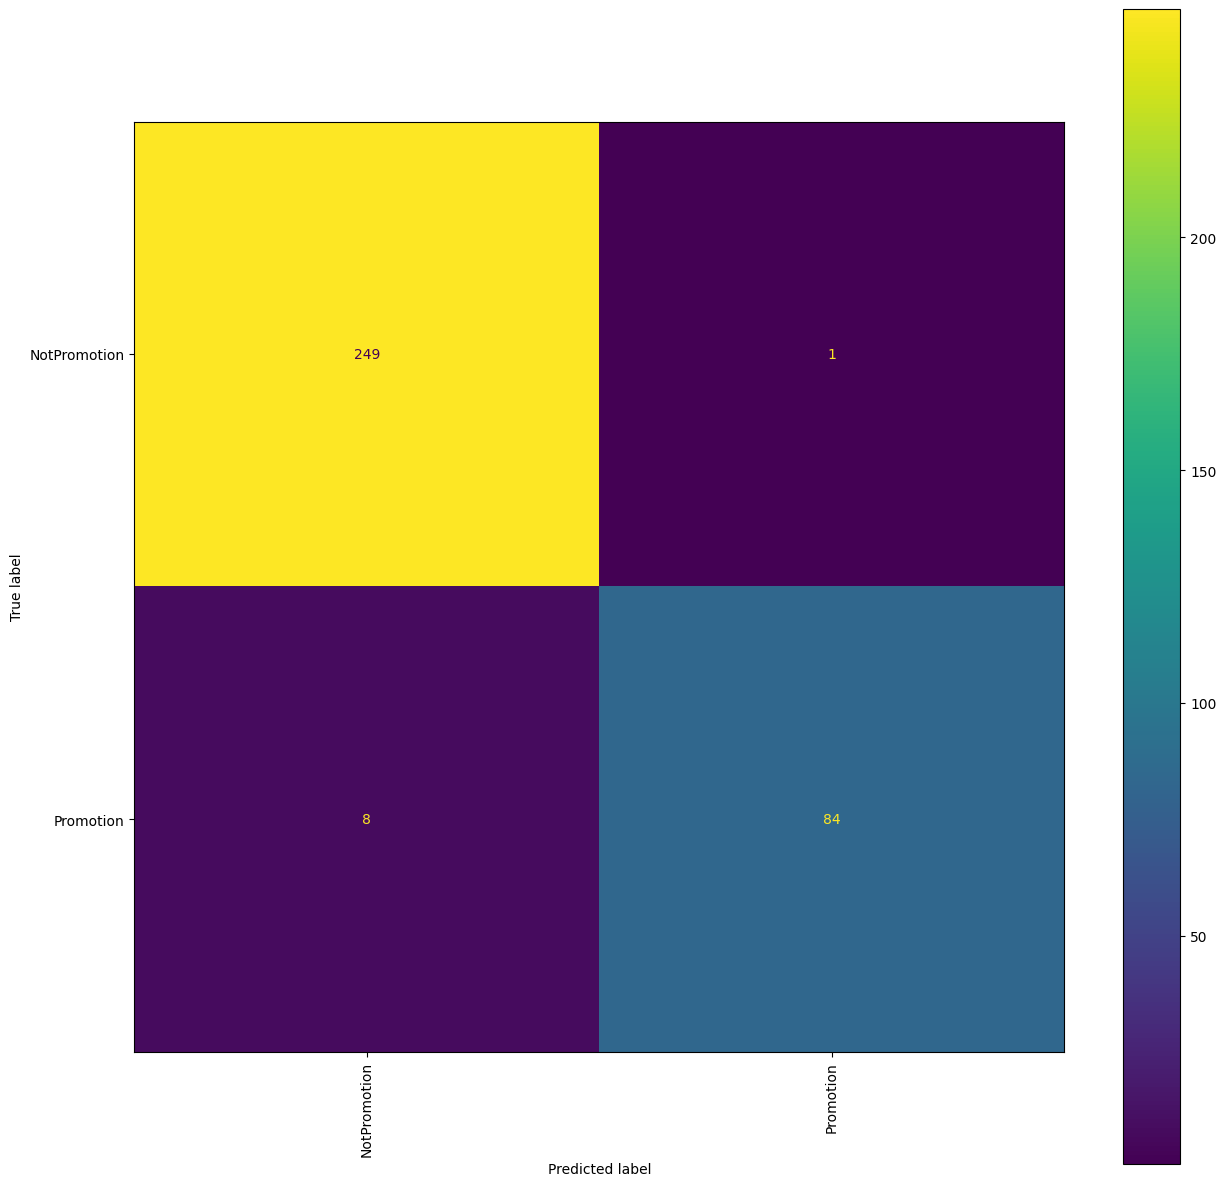

In [15]:
#pred_labels = tf.argmax(pred.logits, axis=1)
#pred_labels = [0 if pred < best_threshold else 1 for pred in pred]
pred_labels = [1 if prob >= best_threshold else 0 for prob in y_probs]

print(f"Accuracy Score: {accuracy_score(test_labels, pred_labels):.4f}")
print(f"Recall Score: {recall_score(test_labels, pred_labels,average='binary'):.4f}")
print(f"Precision Score: {precision_score(test_labels, pred_labels,average='binary'):.4f}")
print(f"F1 Score: {f1_score(test_labels, pred_labels,average='binary'):.4f}")
print(f"Fbeta Score: {fbeta_score(test_labels, pred_labels,beta=0.5,average='binary',pos_label=1):.4f}")

print(f"Classification Report: {classification_report(test_labels, pred_labels,target_names=label_type)}")

display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, pred_labels), display_labels = label_type)

fig, ax = plt.subplots(figsize=(15,15))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')

In [16]:
def predict_sentiment(text):
    use_text = [preprocess_text(t) for t in text]    
    encoding = tokenize_function(use_text)
    pred = model.predict([encoding['input_ids'], encoding['attention_mask']])
    pred_labels = tf.argmax(pred.logits, axis=1)
 
    pred_labels = [label_type[i] for i in pred_labels.numpy().tolist()]
    for index, pred in enumerate(pred_labels):
        print(f"{text[index]}: {pred}")

In [17]:
text = [
    "Aku adalah seorang mahasiswa",
    "Judi Online Disebut Masuk Tahap Sosial, Cak Imin: 8,8 Juta Pasien Minta Direhabilitasi Jumat, 15 Nov",
    "Gacor xxtoto menang pasti dibayar",
    "dp jd jt buruan gas garansi meteorwin",
    "gacor pasti menang di xxtoto",
    "top up di kantorbola pasti gampang menangnya",
    "gratis koin buruan topup di agencasinoindonesia",
    "gratis koin buruan topup di fairbet88.com, segera daftarkan akun anda",
    "DEWA-DORA tuh situs yang paling enak withdraw tiap hari! 😖 😣",
    "DEWA-DORA tuh situs yang paling gampang narik tiap hari! 😖 😣",
    "Gua setia maen di DEWADORA, tempat terbaik!",
    "kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung dan Menang berapapun dibayar."
]
predict_sentiment(text)

1/1 [==============================] - 3s 3s/step
Aku adalah seorang mahasiswa: NotPromotion
Judi Online Disebut Masuk Tahap Sosial, Cak Imin: 8,8 Juta Pasien Minta Direhabilitasi Jumat, 15 Nov: NotPromotion
Gacor xxtoto menang pasti dibayar: Promotion
dp jd jt buruan gas garansi meteorwin: NotPromotion
gacor pasti menang di xxtoto: Promotion
top up di kantorbola pasti gampang menangnya: NotPromotion
gratis koin buruan topup di agencasinoindonesia: Promotion
gratis koin buruan topup di fairbet88.com, segera daftarkan akun anda: Promotion
DEWA-DORA tuh situs yang paling enak withdraw tiap hari! 😖 😣: Promotion
DEWA-DORA tuh situs yang paling gampang narik tiap hari! 😖 😣: Promotion
Gua setia maen di DEWADORA, tempat terbaik!: Promotion
kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung dan Menang berapapun dibayar.: Promotion
